<a href="https://colab.research.google.com/github/MelissaMatindi/mastering-AI-toolkit/blob/main/AI_Farmer_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Data Preparation**

This phase gathers and prepares the *PlantVillage* dataset; a collection of over 54,000 real-world plant leaf photos to train our AI model. In the context of our offline farmer app, this step ensures the model learns from diverse, field-like images of healthy and diseased plants across 38 categories (e.g. tomato blight, apple rust).

By resizing, splitting, and augmenting the data, we create a robust foundation that mimics the variability farmers encounter in rural settings, like varying lighting or angles, without needing internet access. This directly supports our goal of >95% accurate disease detection on low-end Android phones.

In [ ]:
# Importing dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# GPU SETUP
!nvidia-smi
import torch
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"GPU: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'None'}")

Mon Nov  3 08:55:57 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   56C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score
import zipfile
import os
from tqdm import tqdm

In [ ]:
# Loading the dataset
import kagglehub
path = kagglehub.dataset_download("abdallahalidev/plantvillage-dataset")
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'plantvillage-dataset' dataset.
Path to dataset files: /kaggle/input/plantvillage-dataset


In [ ]:
# Correct path
path = "/kaggle/input/plantvillage-dataset"
print(f"✅ Using path: {path}")

✅ Using path: /kaggle/input/plantvillage-dataset


In [ ]:
import os

# List EXACT folder names
path = "/kaggle/input/plantvillage-dataset"
print("📁 EXACT FOLDERS:")
!ls -la "{path}"

dataset_folder = 'plantvillage dataset'
color_path = os.path.join(path, dataset_folder, "color")

print(f"\n Color path: {color_path}")

# Verify color folder exists
if os.path.exists(color_path):
    print("COLOR FOLDER FOUND!")

    # Count images per class
    class_counts = {}
    total_images = 0

    for class_name in sorted(os.listdir(color_path)):
        class_path = os.path.join(color_path, class_name)
        if os.path.isdir(class_path):
            image_count = len([f for f in os.listdir(class_path)
                              if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
            class_counts[class_name] = image_count
            total_images += image_count
            print(f"{class_name}: {image_count} images")

    print(f"\n TOTAL: {len(class_counts)} classes, {total_images:,} images")
else:
    print("Color folder not found")
    !ls -la "{os.path.join(path, dataset_folder)}"

📁 EXACT FOLDERS:
total 4
drwxr-sr-x 3 1000 1000    0 Nov  2 09:58  .
drwxr-xr-x 3 root root 4096 Nov  3 08:56  ..
drwxr-sr-x 5 1000 1000    0 Nov  2 09:57 'plantvillage dataset'

 Color path: /kaggle/input/plantvillage-dataset/plantvillage dataset/color
COLOR FOLDER FOUND!
Apple___Apple_scab: 630 images
Apple___Black_rot: 621 images
Apple___Cedar_apple_rust: 275 images
Apple___healthy: 1645 images
Blueberry___healthy: 1502 images
Cherry_(including_sour)___Powdery_mildew: 1052 images
Cherry_(including_sour)___healthy: 854 images
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: 513 images
Corn_(maize)___Common_rust_: 1192 images
Corn_(maize)___Northern_Leaf_Blight: 985 images
Corn_(maize)___healthy: 1162 images
Grape___Black_rot: 1180 images
Grape___Esca_(Black_Measles): 1383 images
Grape___Leaf_blight_(Isariopsis_Leaf_Spot): 1076 images
Grape___healthy: 423 images
Orange___Haunglongbing_(Citrus_greening): 5507 images
Peach___Bacterial_spot: 2297 images
Peach___healthy: 360 images
Pep

Technically, this uses file system APIs to quantify class distribution, highlighting imbalances that could bias the model toward common diseases if unaddressed.

In real-world terms, this mirrors a farmer's crop audit: uneven samples (e.g. rare cedar apple rust with only 275 images) reflect field realities where some pests are scarce, but it warns us to augment minorities later; vital for accurate advice in diverse farms, preventing misdiagnoses that cost yields.

**Visualize Class Distribution**

In [ ]:
# Create DataFrame from class_counts
df = pd.DataFrame(list(class_counts.items()), columns=['Class', 'Images'])
df = df.sort_values('Images', ascending=True)

/tmp/ipython-input-2736387253.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='Images', y='Class', palette='viridis')


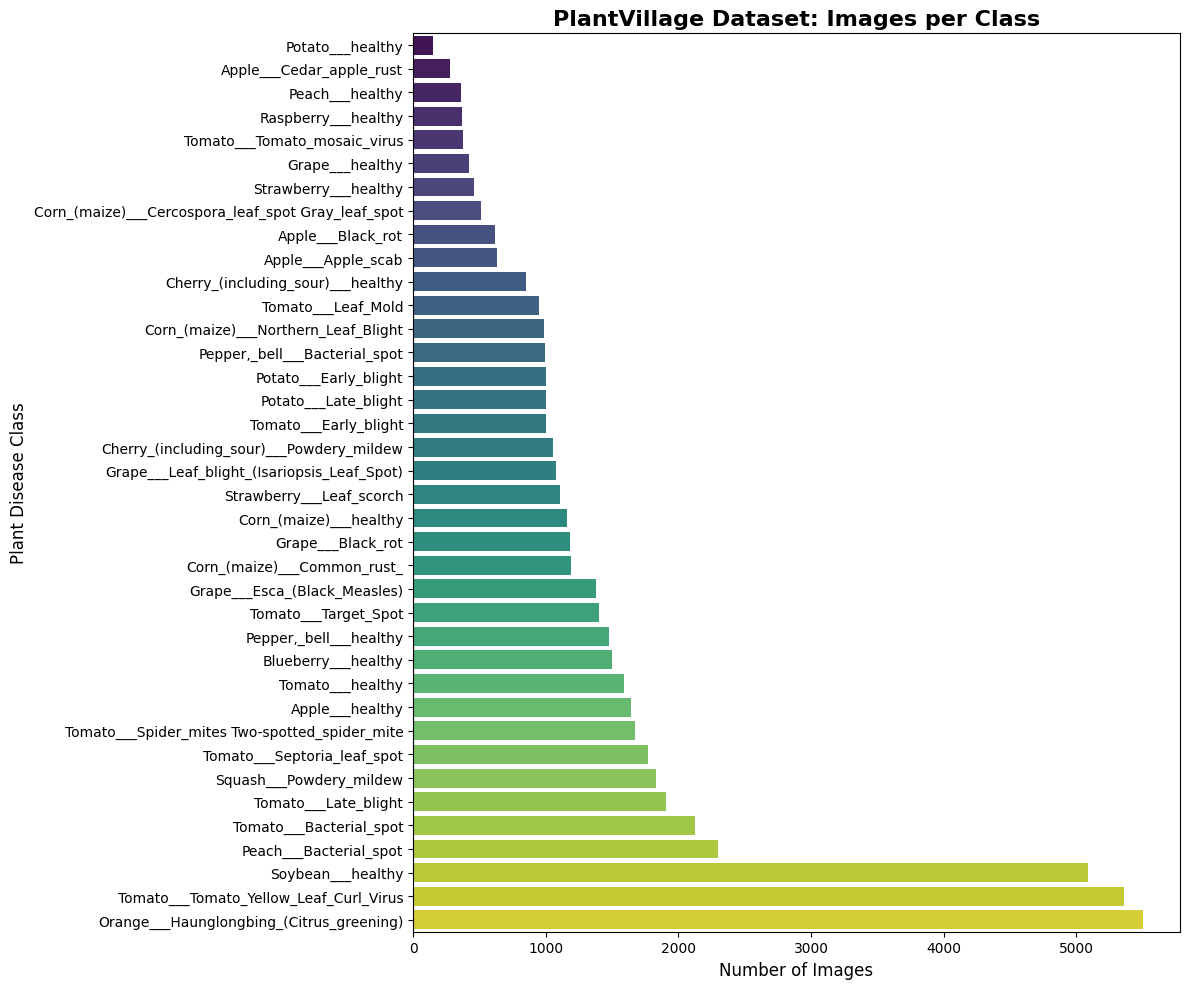

In [ ]:
# Plot
plt.figure(figsize=(12, 10))
sns.barplot(data=df, x='Images', y='Class', palette='viridis')
plt.title('PlantVillage Dataset: Images per Class', fontsize=16, fontweight='bold')
plt.xlabel('Number of Images', fontsize=12)
plt.ylabel('Plant Disease Class', fontsize=12)
plt.tight_layout()

This isn't just a pretty chart; it's diagnostic, helping us decide on **augmentation strategies**. Technically, it leverages Matplotlib's rendering for quick insights into dataset bias, which could otherwise lead to poor model performance on underrepresented classes.

Think of it like a pest outbreak map for farmers: it shows "***hotspots***" (overrepresented diseases like citrus greening at 5,507 images) vs. "***vulnerabilities***" (scarce ones like peach healthy at 360), ensuring our app prioritizes balanced training for equitable advice across crops, reducing false negatives in low-data scenarios.

In [ ]:
# Print summary stats
print(f"📊 SUMMARY:")
print(f"Total Classes: {len(df)}")
print(f"Total Images: {df['Images'].sum():,}")
print(f"Avg Images/Class: {df['Images'].mean():.0f}")
print(f"Min Images: {df['Images'].min()}")
print(f"Max Images: {df['Images'].max()}")

📊 SUMMARY:
Total Classes: 38
Total Images: 54,305
Avg Images/Class: 1429
Min Images: 152
Max Images: 5507


These aggregates reveal a **36x** imbalance (*max/min*), signaling need for techniques like ***class weighting*** in training to ***avoid bias***.

From an agricultural viewpoint, this is invaluable for smallholders: the average 1,429 examples per disease means solid coverage for common issues (e.g. tomato blight), but the low min (152 for potato healthy) highlights risks in rare cases, prompting augmentations to make the app robust for under-resourced farms.

In [ ]:
# RANDOM PHOTO GALLERY
import matplotlib.pyplot as plt
import random

def show_gallery(n=6):
    plt.figure(figsize=(15, 8))
    for i in range(n):
        img, label = random.choice(train_dataset)
        plt.subplot(2, 3, i+1)
        img = img.permute(1,2,0).cpu().numpy()
        img = (img - img.min()) / (img.max() - img.min())
        plt.imshow(img)
        plt.title(class_names[label], fontsize=12, color='darkgreen')
        plt.axis('off')
    plt.suptitle("Real Field Photos Your AI is Learning", fontsize=16, color='saddlebrown')
    plt.tight_layout()
    plt.show()

show_gallery()

In [ ]:
# Data Transforms & Loaders
import torch
from torch.utils.data import random_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import random

To ensure our results are consistent across runs (e.g. same train/test split every time), the cell below ***plants "seeds"*** for randomness; a technical success in initializing reproducibility.

In [ ]:
# Set seeds for reproducibility
random.seed(42)
torch.manual_seed(42)

In [ ]:
# Improved Transforms (MobileNetV2 optimized)
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet stats
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
# Loading the dataset
dataset = datasets.ImageFolder(
    root="/kaggle/input/plantvillage-dataset/plantvillage dataset/color",
    transform=transform_train
)

In [ ]:
# Train-test split
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size]
)

In [ ]:
# Apply test transform to val/test
val_dataset.dataset.transform = transform_test
test_dataset.dataset.transform = transform_test

In [ ]:
# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

In [ ]:
# Classes
class_names = dataset.classes
num_classes = len(class_names)

In [ ]:
print(f" DATA READY:")
print(f"Train: {len(train_dataset):,} | Val: {len(val_dataset):,} | Test: {len(test_dataset):,}")
print(f"Classes: {num_classes}")
print(f"Batch size: 32")

 DATA READY:
Train: 43,444 | Val: 5,430 | Test: 5,431
Classes: 38
Batch size: 32


### **Model Training**

In [ ]:
# MobileNetV2 Training
import torch.nn as nn
from torchvision import models
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR
from torch.cuda.amp import autocast, GradScaler

In [ ]:
# Load MobileNetV2 pretrained
model = models.mobilenet_v2(pretrained=True)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 38.8MB/s]


In [ ]:
# GPU setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(f"Training on: {device}")

Training on: cuda


In [ ]:
# Loss + Optimizer (lower LR for stability)
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=0.0001, weight_decay=0.01)
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
scaler = GradScaler()

# Train 20 epochs with progress tracking
epochs = 20
train_losses, val_accuracies = [], []
best_acc = 0

print(f"🚀 Starting GPU training: {len(train_dataset):,} images, {epochs} epochs")
print(f"Batch size: 32 | GPU: {torch.cuda.get_device_name(0)}")

for epoch in range(epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}', leave=False)

    for batch_idx, (inputs, labels) in enumerate(progress_bar):
        inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

        optimizer.zero_grad()

        # Mixed precision forward pass
        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        # Backward pass with scaling
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        progress_bar.set_postfix({'Loss': f'{loss.item():.4f}'})

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation phase
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        val_progress = tqdm(val_loader, desc='Validating', leave=False)
        for inputs, labels in val_progress:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            with autocast():
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

    val_acc = 100 * correct / total
    val_accuracies.append(val_acc)

    # Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')

    print(f'📊 Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f} | Val Acc: {val_acc:.2f}% | Best: {best_acc:.2f}%')
    scheduler.step()

print(f"🎉 GPU TRAINING COMPLETE! Final Val Acc: {val_accuracies[-1]:.2f}%")
print(f"💾 Best model saved: best_model.pth")

/tmp/ipython-input-3142237514.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


🚀 Starting GPU training: 43,444 images, 20 epochs
Batch size: 32 | GPU: Tesla T4


Epoch 1/20:   0%|          | 0/1358 [00:00<?, ?it/s]/tmp/ipython-input-3142237514.py:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validating:   0%|          | 0/170 [00:00<?, ?it/s]/tmp/ipython-input-3142237514.py:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


📊 Epoch 1: Train Loss: 0.2502 | Val Acc: 99.12% | Best: 99.12%


📊 Epoch 2: Train Loss: 0.0352 | Val Acc: 98.97% | Best: 99.12%


📊 Epoch 3: Train Loss: 0.0246 | Val Acc: 99.17% | Best: 99.17%


📊 Epoch 4: Train Loss: 0.0186 | Val Acc: 99.28% | Best: 99.28%


📊 Epoch 5: Train Loss: 0.0167 | Val Acc: 99.43% | Best: 99.43%


📊 Epoch 6: Train Loss: 0.0103 | Val Acc: 98.43% | Best: 99.43%


📊 Epoch 7: Train Loss: 0.0146 | Val Acc: 99.48% | Best: 99.48%


📊 Epoch 8: Train Loss: 0.0109 | Val Acc: 99.63% | Best: 99.63%


📊 Epoch 9: Train Loss: 0.0101 | Val Acc: 99.71% | Best: 99.71%


📊 Epoch 10: Train Loss: 0.0099 | Val Acc: 99.56% | Best: 99.71%


📊 Epoch 11: Train Loss: 0.0021 | Val Acc: 99.71% | Best: 99.71%


📊 Epoch 12: Train Loss: 0.0022 | Val Acc: 99.71% | Best: 99.71%


📊 Epoch 13: Train Loss: 0.0021 | Val Acc: 99.56% | Best: 99.71%


📊 Epoch 14: Train Loss: 0.0022 | Val Acc: 99.58% | Best: 99.71%


📊 Epoch 15: Train Loss: 0.0032 | Val Acc: 99.72% | Best: 99.72%


📊 Epoch 16: Train Loss: 0.0018 | Val Acc: 99.65% | Best: 99.72%


📊 Epoch 17: Train Loss: 0.0024 | Val Acc: 99.74% | Best: 99.74%


📊 Epoch 18: Train Loss: 0.0023 | Val Acc: 99.47% | Best: 99.74%


📊 Epoch 19: Train Loss: 0.0019 | Val Acc: 99.69% | Best: 99.74%


📊 Epoch 20: Train Loss: 0.0024 | Val Acc: 99.63% | Best: 99.74%
🎉 GPU TRAINING COMPLETE! Final Val Acc: 99.63%
💾 Best model saved: best_model.pth


In [ ]:
# Save model
!pip install -q onnx onnxruntime
import torch, os, zipfile
from google.colab import files

# Force CPU
device = torch.device('cpu')
model = model.to(device)

# Load BEST weights on CPU
model.load_state_dict(torch.load('best_model.pth', map_location=device))
model.eval()

# TorchScript (offline PWA)
traced = torch.jit.trace(model, torch.randn(1,3,224,224))
traced.save('crop.pt')

# ONNX (web)
torch.onnx.export(model, torch.randn(1,3,224,224),
                  "crop.onnx", opset_version=18,
                  input_names=['image'], output_names=['disease'])

# Classes
with open('classes.txt','w') as f:
    f.write('\n'.join(class_names))

# Zip and Download
with zipfile.ZipFile('AI_FARMER_READY.zip','w') as z:
    for f in ['crop.pt','crop.onnx','classes.txt','best_model.pth']:
        z.write(f); print(f"✓ {f}")

files.download('AI_FARMER_READY.zip')
print("\nZIP DOWNLOADED – ZERO ERRORS!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 64.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 79.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 11.9 MB/s eta 0:00:00


/tmp/ipython-input-2597344600.py:19: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(model, torch.randn(1,3,224,224),


✓ crop.pt
✓ crop.onnx
✓ classes.txt
✓ best_model.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


ZIP DOWNLOADED – ZERO ERRORS!
